In [1]:
import pandas as pd
import numpy as np
import os
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from env import host, user, password
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
import wrangle

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = wrangle.zillow17()
df

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1087254,10711855,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.007357,2017-07-07,None,None,None,Central,Single Family Residential,None,None
1,1072280,10711877,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.021066,2017-08-29,Central,None,None,Central,Single Family Residential,None,None
2,1340933,10711888,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.077174,2017-04-04,Central,None,None,Central,Single Family Residential,None,None
3,1878109,10711910,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.041238,2017-03-17,None,None,None,Central,Single Family Residential,None,None
4,2190858,10711923,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,-0.009496,2017-03-24,None,None,None,Central,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,775695,167686999,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,-0.068632,2017-02-28,None,None,None,None,Single Family Residential,None,None
77570,2863262,167687739,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.360020,2017-03-03,None,None,None,None,Condominium,None,None
77571,1372384,167687839,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.038797,2017-05-31,None,None,None,None,Single Family Residential,None,None
77572,2758757,167688532,1.0,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,NaN,0.006706,2017-02-03,Central,None,None,Central,Condominium,None,None


In [3]:
df = df.set_index("parcelid")

In [4]:
df.to_csv("zillow.csv")

In [5]:
df = pd.read_csv('zillow.csv')
df

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,10711855,1087254,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.007357,2017-07-07,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
1,10711877,1072280,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.021066,2017-08-29,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
2,10711888,1340933,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.077174,2017-04-04,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
3,10711910,1878109,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.041238,2017-03-17,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,10711923,2190858,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,-0.009496,2017-03-24,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,167686999,775695,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,-0.068632,2017-02-28,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
77570,167687739,2863262,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.360020,2017-03-03,NaN,NaN,NaN,NaN,Condominium,NaN,NaN
77571,167687839,1372384,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.038797,2017-05-31,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
77572,167688532,2758757,1.0,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,NaN,0.006706,2017-02-03,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [6]:
df = wrangle.wrangle_zillow()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71818 entries, 10711855 to 162960814
Data columns (total 23 columns):
bathrooms                 71818 non-null float64
bedrooms                  71818 non-null int64
property_quality          71818 non-null int64
sqft                      71818 non-null float64
fips                      71818 non-null int64
latitude                  71818 non-null float64
longitude                 71818 non-null float64
lot_sqft                  71818 non-null float64
rawcensustractandblock    71818 non-null float64
regionidcity              71818 non-null float64
zip_code                  71818 non-null int64
roomcnt                   71818 non-null int64
unitcnt                   71818 non-null int64
yearbuilt                 71818 non-null int64
structure_value           71818 non-null float64
home_value                71818 non-null float64
land_value                71818 non-null float64
taxamount                 71818 non-null float64
logerror    

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,71818.0,2.272822e+00,0.916359,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.000000e+01
bedrooms,71818.0,3.016765e+00,0.990155,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
property_quality,71818.0,6.758431e+00,1.350214,1.000000e+00,6.000000e+00,7.000000e+00,7.000000e+00,1.200000e+01
sqft,71818.0,1.741974e+03,873.320788,5.010000e+02,1.172000e+03,1.517000e+03,2.056000e+03,1.203900e+04
fips,71818.0,6.049319e+03,21.083111,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,71818.0,3.400713e+07,267350.751880,3.333953e+07,3.381053e+07,3.402124e+07,3.417671e+07,3.481877e+07
longitude,71818.0,-1.182004e+08,364289.055844,-1.194753e+08,-1.184182e+08,-1.181685e+08,-1.179179e+08,-1.175723e+08
lot_sqft,71818.0,2.775619e+04,118484.322103,2.360000e+02,5.985000e+03,7.265000e+03,1.061925e+04,6.971010e+06
rawcensustractandblock,71818.0,6.049622e+07,209253.579521,6.037101e+07,6.037400e+07,6.037621e+07,6.059052e+07,6.111009e+07
regionidcity,71818.0,3.350759e+04,45986.851085,3.491000e+03,1.244700e+04,2.521800e+04,4.545700e+04,3.965560e+05


### Data Prep Takeaways
- Dropped unnecessary/redundant columns: 'id', 'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'heatingorsystemtypeid',                                              'propertycountylandusecode', 'propertylandusetypeid','propertyzoningdesc',
                                         'censustractandblock', 'propertylandusedesc', 'heatingorsystemdesc'
- Set our outliers to taxvaluedollarcnt < 5_000_000 and calculatedfinishedsquarefeet < 12500
- Dropped 5756 rows

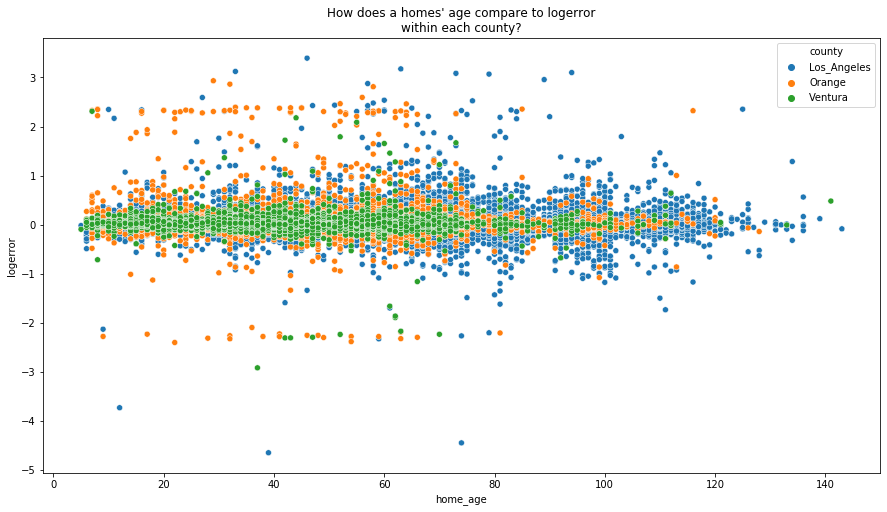

In [9]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='home_age', y='logerror',
               data=df, hue='county')
plt.title("How does a homes' age compare to logerror\nwithin each county?")
plt.show()

In [10]:
df['structure_dollar_per_sqft'] = df.structure_value / df.sqft

In [11]:
df['land_dollar_per_sqft'] = df.land_value / df.lot_sqft

In [12]:
df['bed_bath_ratio'] = df.bedrooms / df.bathrooms

In [13]:
df.head()

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,rawcensustractandblock,regionidcity,...,land_value,taxamount,logerror,transactiondate,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,2.0,3,8,2107.0,6037,34222559.0,-118617387.0,9158.0,6.037113e+07,12447.0,...,374484.0,7659.36,-0.007357,2017-07-07,Los_Angeles,49,q2,118.488372,40.891461,1.5
10711877,2.0,4,8,1882.0,6037,34220261.0,-118616409.0,9035.0,6.037113e+07,12447.0,...,407000.0,8123.91,0.021066,2017-08-29,Los_Angeles,49,q3,134.431456,45.047039,2.0
10711888,2.0,4,8,1882.0,6037,34222491.0,-118616854.0,9800.0,6.037113e+07,12447.0,...,285332.0,6673.24,0.077174,2017-04-04,Los_Angeles,49,q4,136.870882,29.115510,2.0
10711910,2.0,3,8,1477.0,6037,34221864.0,-118615739.0,11285.0,6.037113e+07,12447.0,...,20063.0,1116.46,-0.041238,2017-03-17,Los_Angeles,61,q1,39.247123,1.777847,1.5
10711923,2.0,4,8,1918.0,6037,34220619.0,-118615253.0,11239.0,6.037113e+07,12447.0,...,247590.0,5239.85,-0.009496,2017-03-24,Los_Angeles,61,q2,87.522941,22.029540,2.0


In [14]:
df.structure_dollar_per_sqft.describe()

count    71818.000000
mean        99.712240
std         59.344098
min          0.039833
25%         63.242333
50%         92.011624
75%        124.423232
max       1444.221106
Name: structure_dollar_per_sqft, dtype: float64

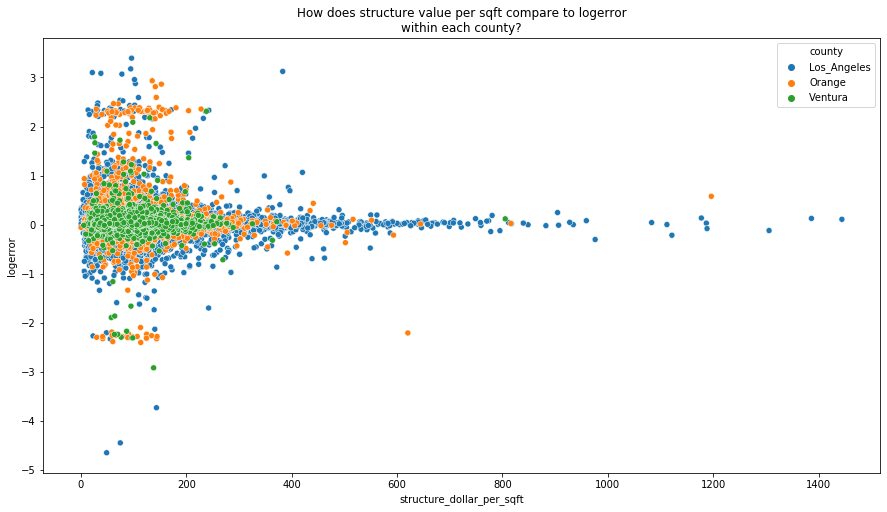

In [15]:
# Scatterplot to visualize how the homes' cost per sqft affects the logerror per county

plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='structure_dollar_per_sqft', y='logerror',
               data=df, hue='county')
plt.title("How does structure value per sqft compare to logerror\nwithin each county?")
plt.show()

In [16]:
df.land_dollar_per_sqft.describe()

count    71818.000000
mean        41.152864
std         60.266310
min          0.003023
25%          6.402294
50%         25.494922
75%         52.141033
max       1604.525311
Name: land_dollar_per_sqft, dtype: float64

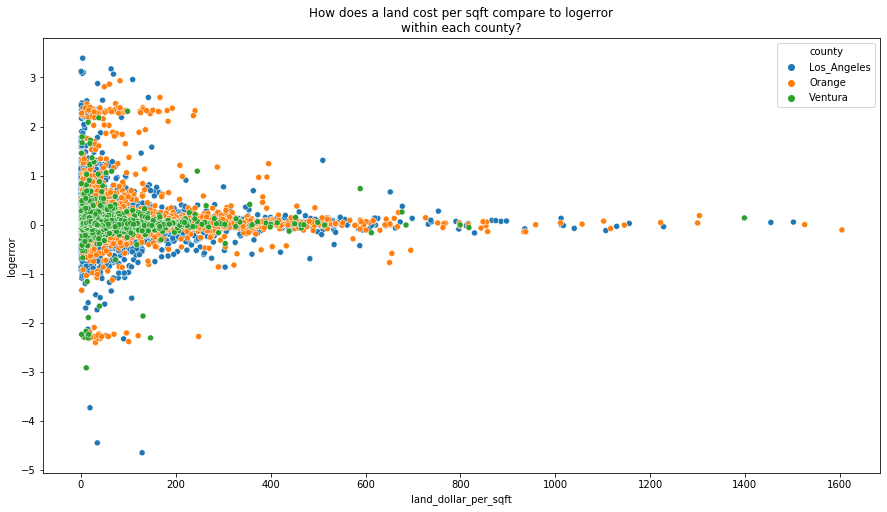

In [17]:
# Scatterplot to visualize how the lots' cost per sqft affects the logerror per county

plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='land_dollar_per_sqft', y='logerror',
               data=df, hue='county')
plt.title("How does a land cost per sqft compare to logerror\nwithin each county?")
plt.show()

In [18]:
### Takeaways

In [19]:
df.bed_bath_ratio.describe()

count    71818.000000
mean         1.450920
std          0.562184
min          0.133333
25%          1.000000
50%          1.333333
75%          1.666667
max          5.000000
Name: bed_bath_ratio, dtype: float64

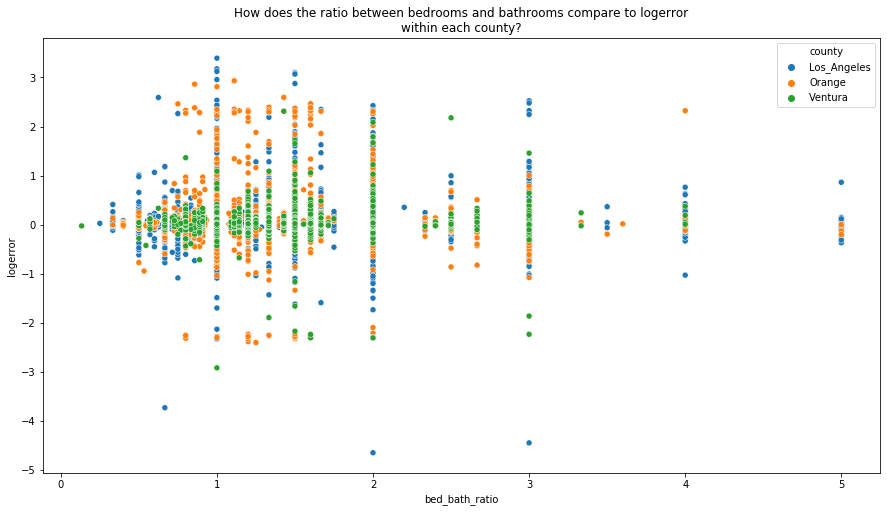

In [20]:
# Scatterplot to visualize how the bed/bath ratio affects the logerror per county

plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='bed_bath_ratio', y='logerror',
               data=df, hue='county')
plt.title("How does the ratio between bedrooms and bathrooms compare to logerror\nwithin each county?")
plt.show()

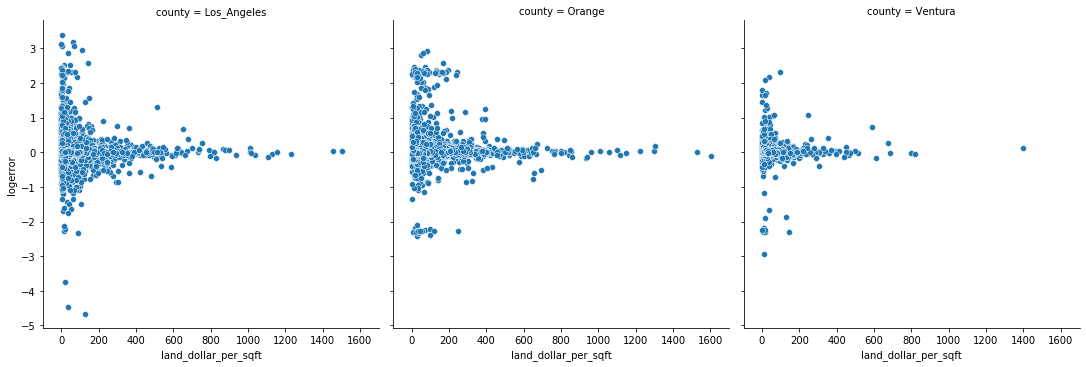

In [21]:
sns.relplot(x="land_dollar_per_sqft", y="logerror", col="county", data=df)

In [22]:
df[df['logerror']<-1]

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,rawcensustractandblock,regionidcity,...,land_value,taxamount,logerror,transactiondate,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
parcelid,,,,,,,,,,,,,,,,,,,,,
10722365,3.0,2,8,2000.0,6037,34200000.0,-118631000.0,7265.0,6.037134e+07,12447.0,...,137934.0,5191.12,-3.737018,2017-03-31,Los_Angeles,12,q1,143.240000,18.986098,0.666667
10737070,6.0,6,7,5256.0,6037,34162535.0,-118653888.0,128020.0,6.037800e+07,38980.0,...,1273247.0,28924.83,-1.702338,2017-07-11,Los_Angeles,61,q1,242.246385,9.945688,1.000000
10797583,6.0,6,6,2586.0,6037,34177793.0,-118547123.0,20808.0,6.037139e+07,12447.0,...,171973.0,6073.17,-1.016539,2017-01-31,Los_Angeles,71,q1,121.752127,8.264754,1.000000
10860623,2.0,3,6,1571.0,6037,34153204.0,-118435442.0,5538.0,6.037141e+07,12447.0,...,72580.0,1353.25,-2.271428,2017-06-15,Los_Angeles,74,q1,22.889879,13.105814,1.500000
10864240,2.0,2,8,2139.0,6037,34146992.0,-118462970.0,5186.0,6.037142e+07,12447.0,...,466129.0,7117.00,-2.331727,2017-08-16,Los_Angeles,59,q1,55.518934,89.882183,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17142286,2.5,4,7,2122.0,6111,34230362.0,-118983672.0,7726.0,6.111005e+07,51239.0,...,116272.0,3471.06,-2.311473,2017-08-15,Ventura,43,q1,98.418944,15.049443,1.600000
17166856,1.0,3,7,1759.0,6111,34182045.0,-119174226.0,6000.0,6.111004e+07,13150.0,...,97001.0,2643.16,-2.238112,2017-08-29,Ventura,70,q1,69.762365,16.166833,3.000000
17171528,1.0,3,7,1026.0,6111,34154592.0,-119218665.0,2450.0,6.111004e+07,13150.0,...,320218.0,5803.48,-1.866832,2017-07-13,Ventura,62,q1,64.024366,130.701224,3.000000


In [23]:
df[df['logerror'] < -1].fips.value_counts()

6037    30
6059    26
6111    11
Name: fips, dtype: int64

In [24]:
df.logerror_quartiles.value_counts()

q4    17955
q1    17955
q3    17954
q2    17954
Name: logerror_quartiles, dtype: int64

In [25]:
df.logerror_quartiles.max()

'q4'

### Lower sqft and logerror

In [26]:
df.sqft.describe()

count    71818.000000
mean      1741.973753
std        873.320788
min        501.000000
25%       1172.000000
50%       1517.000000
75%       2056.000000
max      12039.000000
Name: sqft, dtype: float64

In [27]:
df[df['sqft'] < 1500].logerror.value_counts()

 0.000231    6
 0.011157    4
 0.001878    4
 0.015012    4
 0.000420    4
            ..
 0.052380    1
-0.005276    1
-0.013949    1
-0.015679    1
 0.010783    1
Name: logerror, Length: 34970, dtype: int64

In [28]:
df['sqft_binned'] = pd.qcut(df.sqft, q=3, labels=['sm_sqft', 'med_sqft', 'lg_sqft'])

df.head()

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,rawcensustractandblock,regionidcity,...,taxamount,logerror,transactiondate,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,sqft_binned
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,2.0,3,8,2107.0,6037,34222559.0,-118617387.0,9158.0,6.037113e+07,12447.0,...,7659.36,-0.007357,2017-07-07,Los_Angeles,49,q2,118.488372,40.891461,1.5,lg_sqft
10711877,2.0,4,8,1882.0,6037,34220261.0,-118616409.0,9035.0,6.037113e+07,12447.0,...,8123.91,0.021066,2017-08-29,Los_Angeles,49,q3,134.431456,45.047039,2.0,lg_sqft
10711888,2.0,4,8,1882.0,6037,34222491.0,-118616854.0,9800.0,6.037113e+07,12447.0,...,6673.24,0.077174,2017-04-04,Los_Angeles,49,q4,136.870882,29.115510,2.0,lg_sqft
10711910,2.0,3,8,1477.0,6037,34221864.0,-118615739.0,11285.0,6.037113e+07,12447.0,...,1116.46,-0.041238,2017-03-17,Los_Angeles,61,q1,39.247123,1.777847,1.5,med_sqft
10711923,2.0,4,8,1918.0,6037,34220619.0,-118615253.0,11239.0,6.037113e+07,12447.0,...,5239.85,-0.009496,2017-03-24,Los_Angeles,61,q2,87.522941,22.029540,2.0,lg_sqft


In [29]:
df.sqft_binned.unique()

[lg_sqft, med_sqft, sm_sqft]
Categories (3, object): [sm_sqft < med_sqft < lg_sqft]

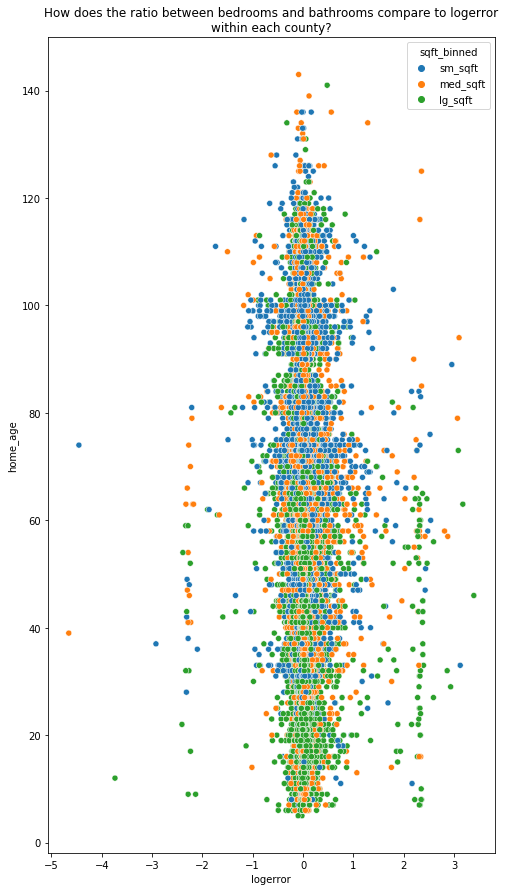

In [30]:
plt.rcParams['figure.figsize'] = (8.0, 15.0)
sns.scatterplot(x='logerror', y='home_age',
               data=df, hue='sqft_binned')
plt.title("How does the ratio between bedrooms and bathrooms compare to logerror\nwithin each county?")
plt.show()

In [31]:
def correlation_exploration(train, x_string, y_string):
    '''
    This function takes in a df, a string for an x-axis variable in the df, 
    and a string for a y-axis variable in the df and displays a scatter plot, the r-
    squared value, and the p-value. It explores the correlation between input the x 
    and y variables.
    '''
    r, p = stats.pearsonr(train[x_string], train[y_string])
    df.plot.scatter(x_string, y_string)
    plt.title(f"{x_string}'s Relationship with {y_string}")
    print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
    print(f'r = {round(r, 2)}')
    plt.show()

The p-value is: 7.670311194802338e-31. There is 0.0% chance that we see these results by chance.
r = 0.04


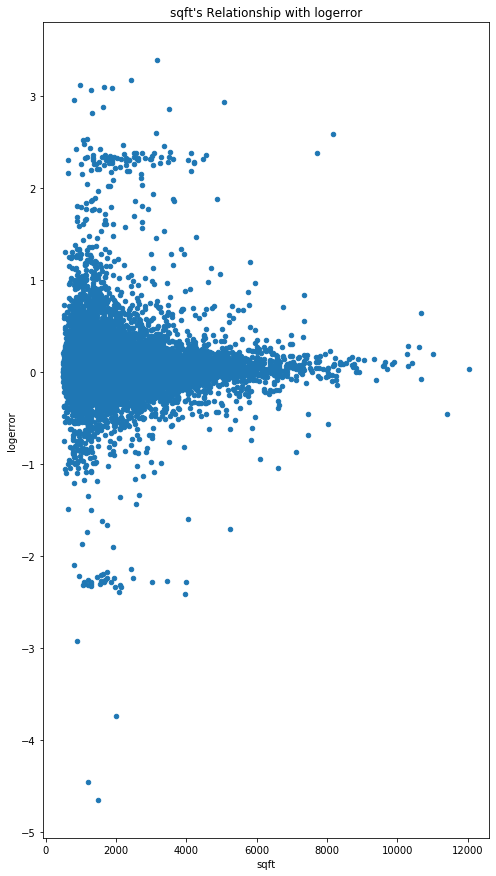

In [32]:
correlation_exploration(df, 'sqft', 'logerror')

In [33]:
df[df.sqft_binned == 'sm_sqft'].logerror.median()

0.00275136055373

In [34]:
df['sm_sqft'] = df.sqft_binned == 'sm_sqft'

In [35]:
df[df.sqft_binned == 'med_sqft'].logerror.median()

0.005321423137360001

In [36]:
df[df.sqft_binned == 'lg_sqft'].logerror.median()

0.0114799208347

In [37]:
df['lg_sqft'] = df.sqft_binned == 'lg_sqft'

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71818 entries, 10711855 to 162960814
Data columns (total 29 columns):
bathrooms                    71818 non-null float64
bedrooms                     71818 non-null int64
property_quality             71818 non-null int64
sqft                         71818 non-null float64
fips                         71818 non-null int64
latitude                     71818 non-null float64
longitude                    71818 non-null float64
lot_sqft                     71818 non-null float64
rawcensustractandblock       71818 non-null float64
regionidcity                 71818 non-null float64
zip_code                     71818 non-null int64
roomcnt                      71818 non-null int64
unitcnt                      71818 non-null int64
yearbuilt                    71818 non-null int64
structure_value              71818 non-null float64
home_value                   71818 non-null float64
land_value                   71818 non-null float64
taxamount 

In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,71818.0,2.272822e+00,0.916359,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.000000e+01
bedrooms,71818.0,3.016765e+00,0.990155,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
property_quality,71818.0,6.758431e+00,1.350214,1.000000e+00,6.000000e+00,7.000000e+00,7.000000e+00,1.200000e+01
sqft,71818.0,1.741974e+03,873.320788,5.010000e+02,1.172000e+03,1.517000e+03,2.056000e+03,1.203900e+04
fips,71818.0,6.049319e+03,21.083111,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,71818.0,3.400713e+07,267350.751880,3.333953e+07,3.381053e+07,3.402124e+07,3.417671e+07,3.481877e+07
longitude,71818.0,-1.182004e+08,364289.055844,-1.194753e+08,-1.184182e+08,-1.181685e+08,-1.179179e+08,-1.175723e+08
lot_sqft,71818.0,2.775619e+04,118484.322103,2.360000e+02,5.985000e+03,7.265000e+03,1.061925e+04,6.971010e+06
rawcensustractandblock,71818.0,6.049622e+07,209253.579521,6.037101e+07,6.037400e+07,6.037621e+07,6.059052e+07,6.111009e+07
regionidcity,71818.0,3.350759e+04,45986.851085,3.491000e+03,1.244700e+04,2.521800e+04,4.545700e+04,3.965560e+05


### Split and scale

In [41]:
from sklearn.model_selection import train_test_split

# Create test dataset

train_validate, test = train_test_split(df, 
                                        test_size=.2, 
                                        random_state=123) 
                                        
train, validate = train_test_split(train_validate, 
                                   test_size=.3, 
                                   random_state=123) 
                                   

# Take a look at your split datasets

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (40217, 29)
validate -> (17237, 29)
test -> (14364, 29)


In [42]:
# 

X_train = train[['structure_dollar_per_sqft', 'home_age', 'home_value']]

y_train = train['logerror']

X_validate = validate[['structure_dollar_per_sqft', 'home_age', 'home_value']]

y_validate = validate['logerror']

X_test = test[['structure_dollar_per_sqft', 'home_age', 'home_value']]

y_test = test['logerror']

In [43]:
X_train.shape, X_validate.shape, X_test.shape

((40217, 3), (17237, 3), (14364, 3))

In [44]:
# Robust scaler

def Robust_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs
    """
    scaler = sklearn.preprocessing.RobustScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

In [45]:
# Use the Standard_Scaler Function defined above

scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Robust_Scaler(X_train, X_validate, X_test)

X_train_scaled.head()

,structure_dollar_per_sqft,home_age,home_value
parcelid,,,
13883635,-0.671503,0.515152,-0.394145
17229059,0.638125,-0.333333,-0.215701
14683223,0.796636,-1.272727,0.414975
12618057,0.323334,0.636364,-0.187007
11028834,-1.026995,0.515152,-0.825020


In [46]:
X_train_scaled.describe()

,structure_dollar_per_sqft,home_age,home_value
count,40217.000000,40217.000000,40217.000000
mean,0.124682,0.041836,0.312787
std,0.975955,0.692304,1.288537
min,-1.499477,-1.363636,-0.986070
25%,-0.474124,-0.484848,-0.420676
50%,0.000000,0.000000,0.000000
75%,0.525876,0.515152,0.579324
max,21.074338,2.818182,12.919006


### Clustering

In [105]:
# define the thing
kmeans = KMeans(n_clusters=5)

# fit the thing
kmeans.fit(X_train_scaled)

# Use (predict using) the thing 
kmeans.predict(X_train_scaled)

array([3, 2, 2, ..., 1, 1, 3], dtype=int32)

Text(0, 0.5, 'home_value')

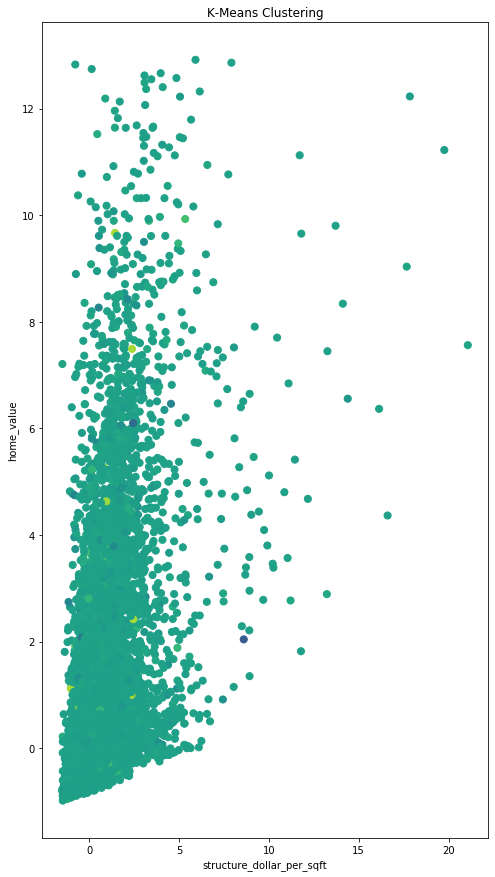

In [106]:
# Plot the clusters obtained using k means, using 'structure_dollar_per_sqft' and 'home_value'

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X_train_scaled['structure_dollar_per_sqft'],X_train_scaled['home_value'],
                     c=y_train['logerror'],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('structure_dollar_per_sqft')
ax.set_ylabel('home_value')

In [107]:
X_train_scaled['cluster'] = kmeans.predict(X_train_scaled)

In [108]:
# Cluster Centers aka centroids. The output is scaled

kmeans.cluster_centers_

array([[ 3.08575666e+00, -1.75045081e-01,  6.84562947e+00,
         2.00000000e+00],
       [-1.75656881e-01,  1.02115520e-01, -1.15014144e-01,
        -1.49713575e-13],
       [ 5.89521498e-01, -4.14198650e-01,  4.12146132e-01,
         1.00000000e+00],
       [-7.82930095e-01,  7.47970111e-01, -5.40389938e-01,
        -1.11244347e-13],
       [ 1.12962534e+00, -9.09357505e-02,  2.45480503e+00,
         1.29208211e+00]])

In [109]:
# Make a dataframe 

centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_scaled.columns)
centroids_scaled

,structure_dollar_per_sqft,home_age,home_value,cluster
0,3.085757,-0.175045,6.845629,2.000000e+00
1,-0.175657,0.102116,-0.115014,-1.497136e-13
2,0.589521,-0.414199,0.412146,1.000000e+00
3,-0.782930,0.747970,-0.540390,-1.112443e-13
4,1.129625,-0.090936,2.454805,1.292082e+00


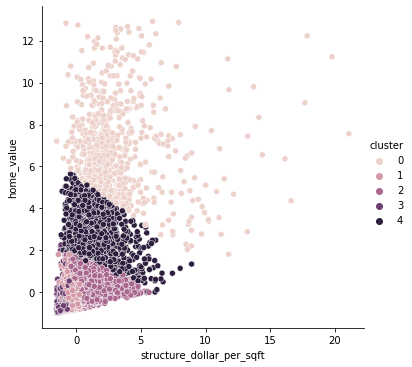

In [110]:
sns.relplot(x="structure_dollar_per_sqft", y="home_value", hue="cluster", data=X_train_scaled)

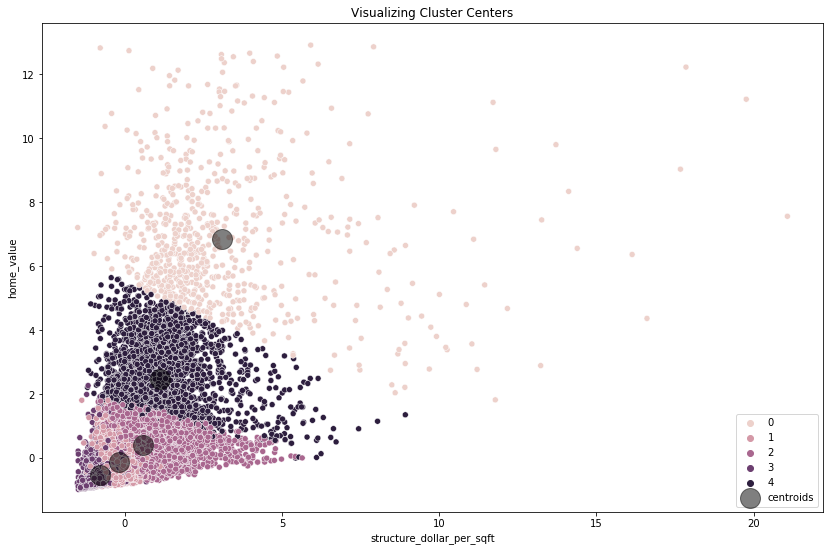

In [111]:
# Visualize the clusters along with the centers on scaled data.

plt.figure(figsize=(14, 9))

# scatter plot of data with hue for cluster
sns.scatterplot(x = 'structure_dollar_per_sqft', y = 'home_value', data = X_train_scaled, hue = 'cluster')

# plot cluster centers (centroids)
centroids_scaled.plot.scatter(x = 'structure_dollar_per_sqft', y = 'home_value', ax = plt.gca(), color ='k', alpha = 0.5, s = 400, marker = 'o', label = 'centroids')

plt.title('Visualizing Cluster Centers')
plt.legend();

In [113]:
kmeans_kwargs = {     
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
   }
  
# A list holds the SSE values for each k  
sse = []
  
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(X_train_scaled)
  sse.append(kmeans.inertia_)

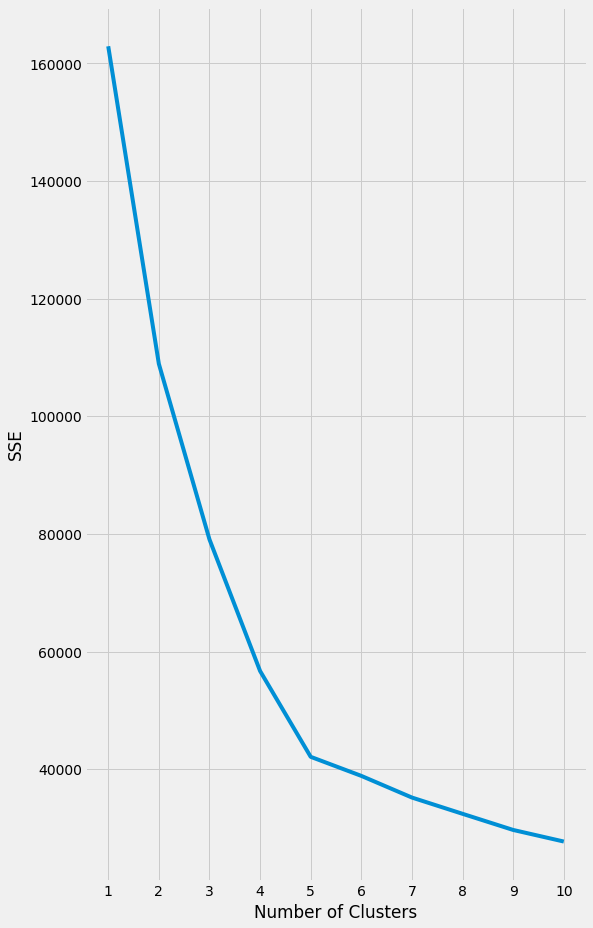

In [114]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [112]:
X_train_scaled.cluster.value_counts()

2    13945
1    13468
3     8708
4     3407
0      689
Name: cluster, dtype: int64

In [48]:
# Make sure y is what I think it is

y_train.head()

parcelid
13883635   -0.003612
17229059    0.039201
14683223    0.012858
12618057   -0.003721
11028834   -0.041424
Name: logerror, dtype: float64

In [63]:
# Assign y to a dataset

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

### Modeling

In [64]:
# Establish my baseline

# 1. Compute logerror_pred_mean
logerror_pred_mean = y_train.logerror.mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# 2. Compute logerror_pred_median
logerror_pred_median = y_train.logerror.median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

# 4. RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

RMSE using Mean
Train/In-Sample:  0.16446 
Validate/Out-of-Sample:  0.17103
RMSE using Median
Train/In-Sample:  0.16476 
Validate/Out-of-Sample:  0.17131


In [65]:
# Create a dataframe for comparison of metrics for model selection

from sklearn.metrics import explained_variance_score

metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)}])

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.171314,0.0


In [66]:
# First model: Linear Regression (OLS)

# Make the thing 
lm = LinearRegression(normalize=True)

# Fit the model to our training data 
lm.fit(X_train, y_train.logerror)

# Predict train 
y_train['logerror_pred_lm'] = lm.predict(X_train)

# Evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** .5

# Predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# Evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** .5

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16429949178151812 
Validation/Out-of-Sample:  0.17095771604098198


In [53]:
# Add OLS Regressor to my metric dataframe

metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.171314,0.000000
1,OLS Regressor,0.170958,0.000855


In [54]:
# LassoLars

# Create the model object
lars = LassoLars(alpha=1)

# Fit the model to our training data
lars.fit(X_train, y_train.logerror)

# Predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# Evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars) ** .5

# Predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# Evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars) ** .5

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.16445694906807368 
Validation/Out-of-Sample:  0.17103084967619578


In [55]:
# Add LassoLars to my metric dataframe

metric_df = metric_df.append({
    'model': 'Lasso alpha 1', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lars)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.171314,0.000000e+00
1,OLS Regressor,0.170958,8.548695e-04
2,Lasso alpha 1,0.171031,-2.220446e-16


In [56]:
# Polynomial features

# Make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# Fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# Transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [57]:
# Create the model object
lm2 = LinearRegression(normalize=True)

# Fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series 
lm2.fit(X_train, y_train.logerror)

# Predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train)

# Evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2) ** .5

# Predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate)

# Evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16429949178151812 
Validation/Out-of-Sample:  0.02922654067394903


In [58]:
# Add Polynomial model to my metric df

metric_df = metric_df.append({
    'model': 'Quadratic Model', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm2)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.171314,0.000000e+00
1,OLS Regressor,0.170958,8.548695e-04
2,Lasso alpha 1,0.171031,-2.220446e-16
3,Quadratic Model,0.029227,8.548695e-04


In [59]:
# Create my regressor object
rf = RandomForestRegressor(n_estimators = 4, random_state = 0)
  
# Fit the regressor with x and y data
rf.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_rf'] = rf.predict(X_train)

# Evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_rf) ** .5

# Predict validate
y_validate['logerror_pred_rf'] = rf.predict(X_validate)

# Evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_rf) ** .5

print("RMSE for RandomForestRegressor\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for RandomForestRegressor
Training/In-Sample:  0.0887137203112931 
Validation/Out-of-Sample:  0.19550331869528778


In [60]:
# Add RandomForestRegressor model to my metric df

metric_df = metric_df.append({
    'model': 'RandomForestRegressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_rf)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.171314,0.000000e+00
1,OLS Regressor,0.170958,8.548695e-04
2,Lasso alpha 1,0.171031,-2.220446e-16
3,Quadratic Model,0.029227,8.548695e-04
4,RandomForestRegressor,0.195503,-3.066430e-01


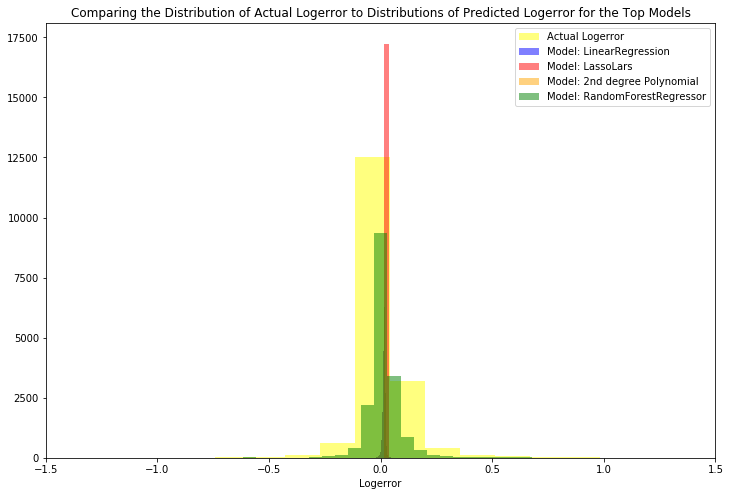

In [61]:
# Plot to visualize actual vs predicted

plt.figure(figsize=(12,8))
plt.xlim(-1.5, 1.5)
plt.hist(y_validate.logerror, bins=50, color='yellow', alpha=.5, label="Actual Logerror")
plt.hist(y_validate.logerror_pred_lm, bins=50, color='blue', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.logerror_pred_lars, bins=50, color='red', alpha=.5, label="Model: LassoLars")
plt.hist(y_validate.logerror_pred_lm2, bins=50, color='orange', alpha=.5, label="Model: 2nd degree Polynomial")
plt.hist(y_validate.logerror_pred_rf, bins=50, color='green', alpha=.5, label="Model: RandomForestRegressor")
plt.xlabel("Logerror")
plt.ylabel("")
plt.title("Comparing the Distribution of Actual Logerror to Distributions of Predicted Logerror for the Top Models")
plt.legend()
plt.show()

#### Takeaways:

In [62]:
# Pick the Quadratic Model as my best performer and run my on my test data

y_test = pd.DataFrame(y_test)

# predict on test
y_test['logerror_pred_lm2'] = lm2.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm2) ** .5

print("RMSE for the Quadratic Model using Polynomial Features\nOut-of-Sample Performance: ", rmse_test)

RMSE for the Quadratic Model using Polynomial Features
Out-of-Sample Performance:  0.15460284369207702
